In [45]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse
from yellowbrick.regressor import ResidualsPlot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading data and initial preprocessing

In [2]:
raw_data = pd.read_csv('AirQualityUCI.csv', header=0, sep=';')

In [3]:
raw_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [4]:
data = raw_data[[col for col in raw_data.columns if 'Unnamed' not in col]].dropna()
data['datetime'] = data['Date'] + ' ' + data['Time'].apply(lambda line: line.replace('.', ':'))
data.drop(['Date', 'Time'], inplace=True, axis=1)
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
for col in data.columns:
    if col != 'datetime' and 'float' not in str(data[col].dtype):
        data[col] = data[col].apply(lambda value: value.replace(',', '.'))
        data[col] = data[col].astype('double')

In [6]:
data = data.replace({-200.0: np.nan})

In [7]:
data.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'datetime'],
      dtype='object')

In [8]:
for chem in ['CO', 'NMHC', 'C6H6', 'NO2', 'O3', 'NOx']:
    for col in data.columns:
        if col.startswith(chem):
            data.rename(columns={col: chem}, inplace=True)
        elif chem in col:
            data.rename(columns={col: 'sensor_{}'.format(chem)}, inplace=True)

In [9]:
data.head()

,CO,sensor_CO,NMHC,C6H6,sensor_NMHC,NOx,sensor_NOx,NO2,sensor_NO2,sensor_O3,T,RH,AH,datetime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-10-03 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-10-03 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-10-03 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-10-03 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-10-03 22:00:00


# Checking the distributions

Since we are going to investigate the correlations between the columns, let's have a look at their distributions to find out which test (Spearman or Pearson) to use.

/usr/local/lib/python3.5/dist-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


CO : is normal - True, p-value = 1.0


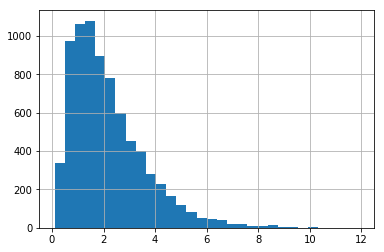

sensor_CO : is normal - True, p-value = 1.0


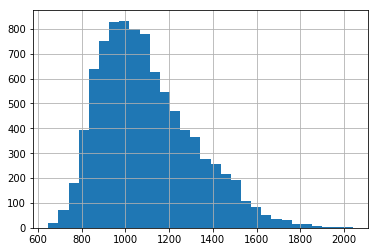

NMHC : is normal - True, p-value = 1.0


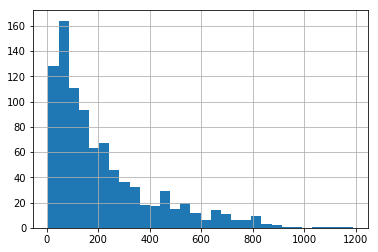

C6H6 : is normal - True, p-value = 1.0


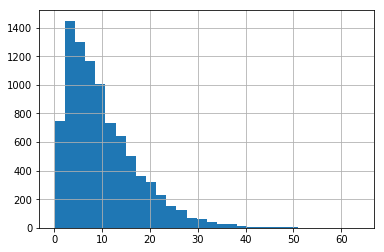

sensor_NMHC : is normal - True, p-value = 1.0


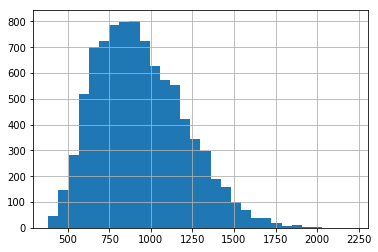

NOx : is normal - True, p-value = 1.0


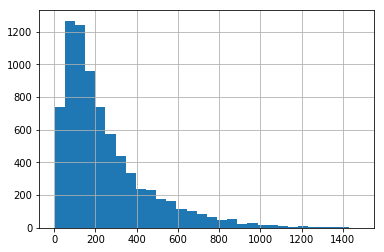

sensor_NOx : is normal - True, p-value = 1.0


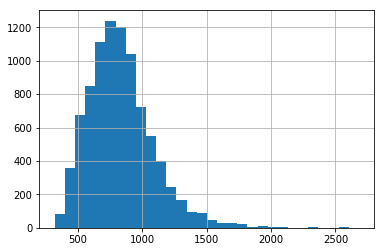

NO2 : is normal - True, p-value = 1.0


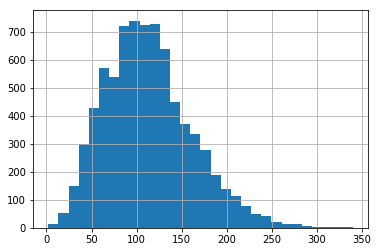

sensor_NO2 : is normal - True, p-value = 1.0


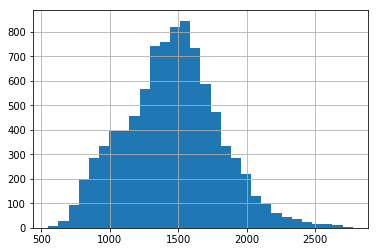

sensor_O3 : is normal - True, p-value = 1.0


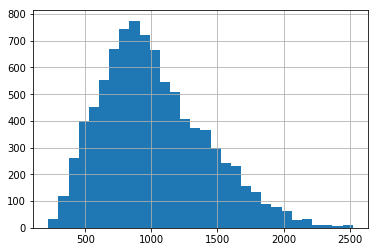

T : is normal - True, p-value = 1.0


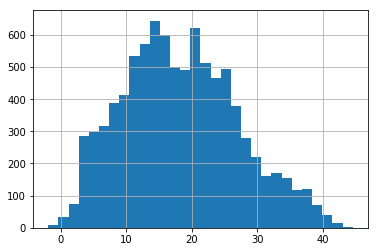

RH : is normal - True, p-value = 1.0


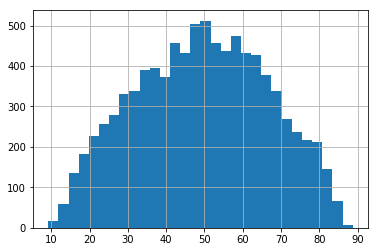

AH : is normal - True, p-value = 1.0


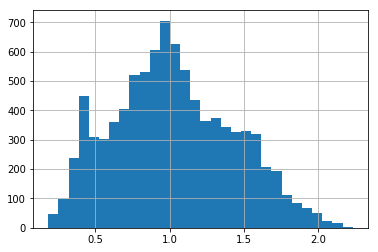

In [10]:
def check_is_normal(sample, p):
    p_value = stats.shapiro(sample)[1]
    return p_value > p, p_value

for col in data.columns:
    if col != 'datetime':
        data[col].hist(bins=30)
        print('{} : is normal - {}, p-value = {}'.format(col, *check_is_normal(data[col], 0.05)))
        plt.show()

As we can see, the most of the values are distributed non-normally, so we will be using Spearman's test to check the correlation between them later on.

# Dealing with NaN values

In [11]:
data.isna().sum()

CO             1683
sensor_CO       366
NMHC           8443
C6H6            366
sensor_NMHC     366
NOx            1639
sensor_NOx      366
NO2            1642
sensor_NO2      366
sensor_O3       366
T               366
RH              366
AH              366
datetime          0
dtype: int64

Let's drop the lines that contain only NaN values

In [12]:
from operator import and_
from functools import reduce


data = data[~reduce(and_, [data[col].isna() for col in data.columns if col != 'datetime'])]

Dropping the NMHC column since almost all of its values are NaN

In [13]:
data = data.drop('NMHC', axis=1)

Also for some reason the number of NaNs in all of the sensor columns are equal. Let's check if this means that all those columns have NaNs in same lines, and if it is so let's drop those lines, since they have too few valuable columns.

In [14]:
data = data[~reduce(and_, [data[col].isna() for col in [sensor for sensor in data.columns if sensor.startswith('sensor')]])]

In [15]:
data.isna().sum()

CO             1647
sensor_CO         0
C6H6              0
sensor_NMHC       0
NOx            1595
sensor_NOx        0
NO2            1598
sensor_NO2        0
sensor_O3         0
T                 0
RH                0
AH                0
datetime          0
dtype: int64

Now we have NaN values only in 3 chemical columns. Actually, we should expect a correlation between the sensor data and the actual amount of corresponding chemicals, so lets investigate into this:

SpearmanrResult(correlation=0.8794221473544893, pvalue=0.0)

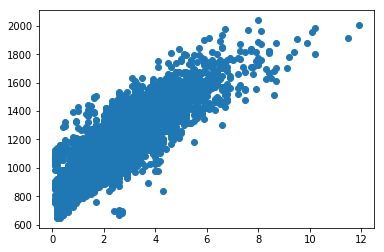

In [16]:
plt.scatter(data['CO'], data['sensor_CO'])

nanless_data = data.dropna(subset=['CO'])
stats.spearmanr(nanless_data['CO'], nanless_data['sensor_CO'])

We definetely have a strong linear dependency between theese columns. This means that we should drop one of them, so let's get rid of CO since it hase a lot of NaN values.

In [17]:
data = data.drop('CO', axis=1)

Let's check the correlations between NOx and some other columns:

Correlation between NOx and sensor_CO: 0.7248448604963139


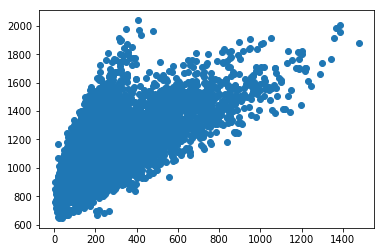

Correlation between NOx and C6H6: 0.7047022264520671


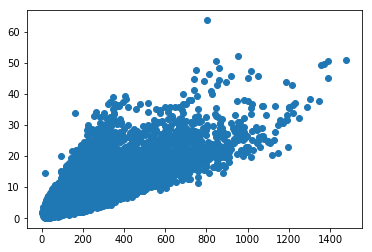

Correlation between NOx and sensor_NMHC: 0.7047381113307565


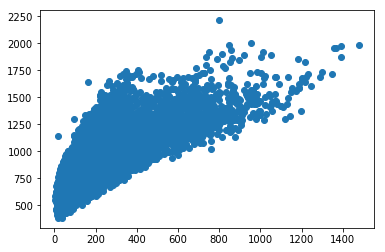

Correlation between NOx and sensor_NOx: 0.7903855395013791


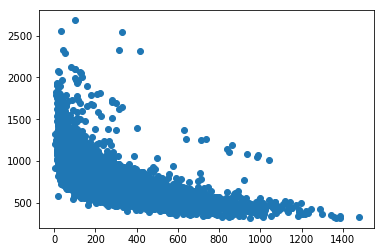

Correlation between NOx and sensor_O3: 0.7930147620895429


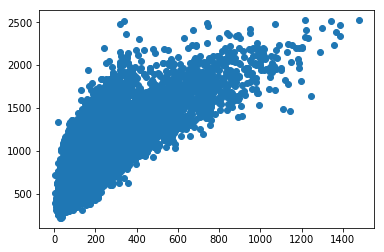

In [18]:
nanless_data = data.dropna(subset=['NOx'])
for col in data.columns:
    if col not in ['datetime', 'NOx']:
        correlation = abs(stats.spearmanr(nanless_data['NOx'], nanless_data[col])[0])
        if correlation > 0.7:
            print('Correlation between NOx and {}: {}'.format(col, correlation))
            plt.scatter(nanless_data['NOx'], nanless_data[col])
            plt.show()

That's quite a lot of correlations, and the last one of them (NOx and sensor_O3) seems quite significant, so let's just drop the NOx column.

In [19]:
data.drop('NOx', inplace=True, axis=1)

Now let's investigate NO2

Correlation between NO2 and sensor_O3: 0.7086210424156435


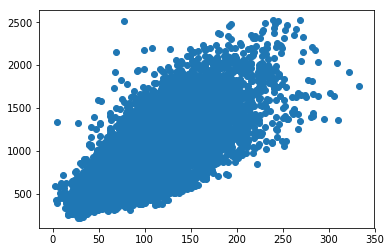

In [20]:
nanless_data = data.dropna(subset=['NO2'])
for col in data.columns:
    if col not in ['datetime', 'NO2']:
        correlation = abs(stats.spearmanr(nanless_data['NO2'], nanless_data[col])[0])
        if correlation > 0.7:
            print('Correlation between NO2 and {}: {}'.format(col, correlation))
            plt.scatter(nanless_data['NO2'], nanless_data[col])
            plt.show()

NO2 seems to correlate a bit only with sensor_O3, but we cannot assume this correlation to be singnificant, so we will keep the NO2 column and fill the NaN values with the mean value of this column.

In [21]:
data.fillna({'NO2': np.nanmean(data['NO2'])}, inplace=True)

# Other correlations:

sensor_CO and C6H6: 0.8894804927317767


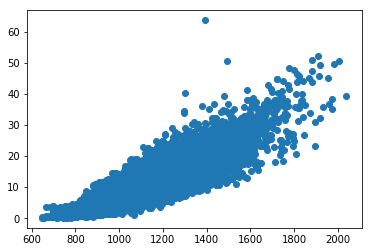

sensor_NMHC and sensor_CO: 0.8894903458242425


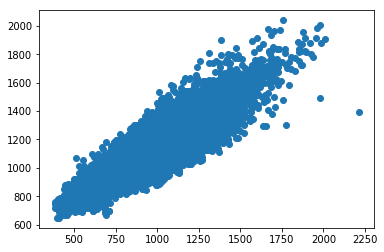

sensor_NMHC and C6H6: 0.9999843886917534


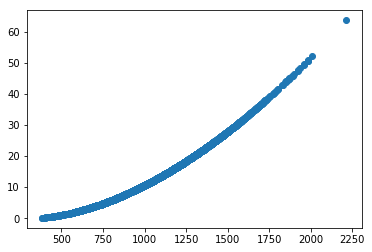

sensor_NOx and sensor_CO: 0.8540993533820878


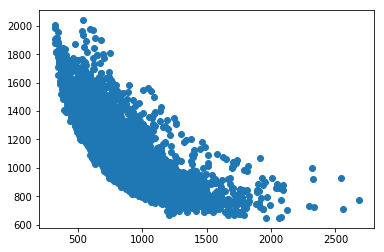

sensor_NOx and C6H6: 0.8503596457092865


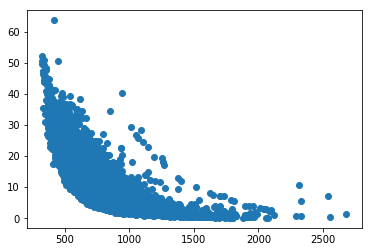

sensor_NOx and sensor_NMHC: 0.8503465984066899


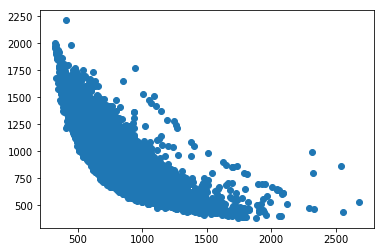

sensor_O3 and sensor_CO: 0.8942917547786483


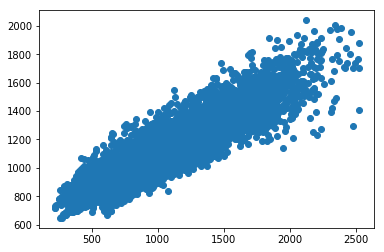

sensor_O3 and C6H6: 0.8738226501132886


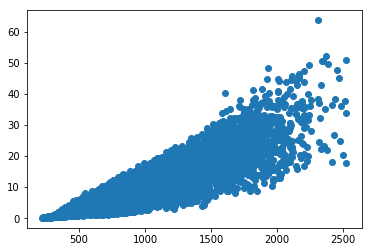

sensor_O3 and sensor_NMHC: 0.8738364446187913


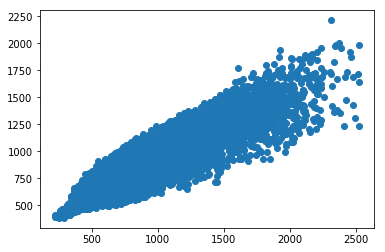

sensor_O3 and sensor_NOx: 0.8624215519389556


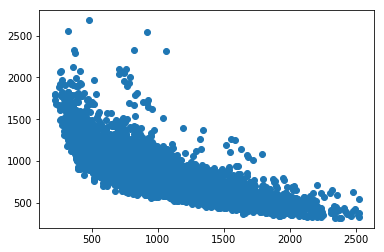

In [22]:
for col1 in data.columns:
    for col2 in data.columns:
        if col1 > col2 and col1 != 'datetime' and col2 != 'datetime':
            correlation = abs(stats.spearmanr(data[col1], data[col2])[0])
            if correlation > 0.8:
                print('{} and {}: {}'.format(col1, col2, correlation))
                plt.scatter(data[col1], data[col2])
                plt.show()

As we can see, sensor_CO and sensor_O3 have quite a strong correlation between each other and sensor_NMHC, so we will definetely drop them.

In [23]:
data.drop('sensor_CO', inplace=True, axis=1)
data.drop('sensor_O3', inplace=True, axis=1)

In [24]:
data.columns

Index(['C6H6', 'sensor_NMHC', 'sensor_NOx', 'NO2', 'sensor_NO2', 'T', 'RH',
       'AH', 'datetime'],
      dtype='object')

Also it looks like sensor_NMHC and C6H6, our target, has some kind of a very strong direct dependency, we just can't be sure which kind.

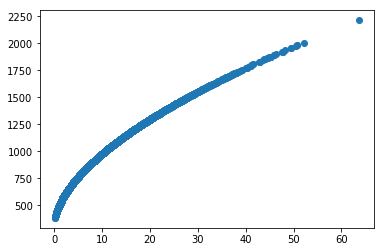

In [25]:
plt.scatter(data['C6H6'], data['sensor_NMHC'])

# Features aggregation:

In [26]:
featured_data = data.copy()
featured_data['NMHC_squared'] = featured_data['sensor_NMHC'] ** 2
featured_data['NMHC_cubed'] = featured_data['sensor_NMHC'] ** 3
featured_data['NMHC_root'] = featured_data['sensor_NMHC'] ** 0.5
featured_data['NMHC_inverse'] = 1 / featured_data['sensor_NMHC']
featured_data['NMHC_log'] = np.log(featured_data['sensor_NMHC'])
        
feature_fields = [col for col in featured_data.columns if col not in ['C6H6', 'datetime']]

In [27]:
featured_data.columns

Index(['C6H6', 'sensor_NMHC', 'sensor_NOx', 'NO2', 'sensor_NO2', 'T', 'RH',
       'AH', 'datetime', 'NMHC_squared', 'NMHC_cubed', 'NMHC_root',
       'NMHC_inverse', 'NMHC_log'],
      dtype='object')

# Generating train/test splits for cross-validation

In [28]:
np.random.seed(1)

featured_data.sort_values('datetime', inplace=True)

tscv = TimeSeriesSplit(n_splits=7)

folds = list(tscv.split(featured_data))

# Function to train, predict and evaluate the model:

In [29]:
def evaluate(model, metric, scale=True):
    results = []
    for train_ind, test_ind in folds:
        X_train = featured_data.iloc[train_ind][feature_fields]
        X_test = featured_data.iloc[test_ind][feature_fields]
        y_train = featured_data.iloc[train_ind]['C6H6']
        y_test = featured_data.iloc[test_ind]['C6H6']
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        model.fit(X_train, y_train)
        
        scores = model.predict(X_test)
        scores = np.array([score if score > 0 else 0 for score in scores])
        residuals = y_test - scores
        results.append(metric(y_test, scores))
    
    results = np.array(results)
    print("Mean metric: ", results.mean())
    print("Metrics std: ", results.std())
    print("Metrics per fold: ", results)
    return model

def coefs(model):
    return pd.DataFrame({'feature': feature_fields, 'importance': model.coef_}).sort_values('importance', ascending=False)

# Least squares approximation

In [30]:
model = LinearRegression()
model = evaluate(model, metric=mae)

Mean metric:  0.02557766494966691
Metrics std:  8.357787006414934e-05
Metrics per fold:  [0.02561307 0.0257244  0.02552863 0.02542582 0.02556876 0.02558175
 0.02560123]


In [31]:
coefs(model)

,feature,importance
7,NMHC_squared,7.952261
0,sensor_NMHC,1.723997
4,T,0.001064
1,sensor_NOx,0.000649
5,RH,0.000440
6,AH,0.000419
2,NO2,-0.000421
3,sensor_NO2,-0.001458
10,NMHC_inverse,-0.074934
8,NMHC_cubed,-0.495590


# SGD Regression

**With squared loss:**

In [32]:
model = SGDRegressor(tol=0.00000001, max_iter=1000, penalty='l2', alpha=0.00001, loss='squared_loss', learning_rate='adaptive')
model = evaluate(model, metric=mae)

Mean metric:  0.04160819955876409
Metrics std:  0.005245185258502308
Metrics per fold:  [0.04261136 0.03836532 0.03694163 0.04060994 0.04911048 0.04894806
 0.03467062]


In [33]:
coefs(model)

,feature,importance
7,NMHC_squared,3.994093
0,sensor_NMHC,2.444088
8,NMHC_cubed,1.381809
9,NMHC_root,0.968652
10,NMHC_inverse,0.951258
3,sensor_NO2,0.015646
5,RH,0.005131
2,NO2,0.003100
4,T,0.002602
1,sensor_NOx,-0.006312


**With huber loss:**

In [34]:
model = SGDRegressor(tol=0.00000001, max_iter=1000, penalty='l2', alpha=0.0001, loss='huber', epsilon=0.05, learning_rate='adaptive')
model = evaluate(model, metric=mae)

Mean metric:  0.03972177066412389
Metrics std:  0.006610341393715031
Metrics per fold:  [0.04013561 0.03390676 0.0325358  0.04196732 0.04872449 0.04855407
 0.03222834]


In [35]:
coefs(model)

,feature,importance
7,NMHC_squared,3.158942
0,sensor_NMHC,2.194200
8,NMHC_cubed,1.995538
10,NMHC_inverse,1.231133
9,NMHC_root,1.212406
11,NMHC_log,0.164317
3,sensor_NO2,0.005476
5,RH,0.003298
2,NO2,0.002663
4,T,0.002567


**With epsilon insensitive loss:**

In [36]:
model = SGDRegressor(tol=0.0000000001, max_iter=250, penalty='elasticnet', alpha=0.0001, loss='epsilon_insensitive', epsilon=0.001, learning_rate='adaptive')
model = evaluate(model, metric=mae)

Mean metric:  0.03271778462525502
Metrics std:  0.004323980598412016
Metrics per fold:  [0.03707847 0.03199302 0.03020605 0.03506546 0.03921394 0.02968773
 0.02577983]


In [37]:
coefs(model)

,feature,importance
7,NMHC_squared,6.128900
0,sensor_NMHC,2.950680
8,NMHC_cubed,0.218616
9,NMHC_root,0.071968
4,T,0.001388
5,RH,0.001119
3,sensor_NO2,0.000300
1,sensor_NOx,0.000000
6,AH,0.000000
2,NO2,-0.000405


# LGBM just for fun

In [38]:
model = LGBMRegressor(n_estimators=1500, learning_rate=0.05, num_leaves=10, objective='mae', random_state=1, max_depth=10)
model = evaluate(model, metric=mae)

Mean metric:  0.0779803894550993
Metrics std:  0.040667030545893205
Metrics per fold:  [0.14993784 0.05436639 0.0388561  0.10257131 0.11369402 0.04581626
 0.04062082]


In [39]:
pd.DataFrame({'feature': feature_fields, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,sensor_NMHC,8899
10,NMHC_inverse,2842
7,NMHC_squared,1599
9,NMHC_root,101
8,NMHC_cubed,42
11,NMHC_log,7
1,sensor_NOx,0
2,NO2,0
3,sensor_NO2,0
4,T,0


# Analysing the results

**Features**

After all this runs we can make a conclusion, that the best features to use are the features derived from sensor_NMHC. In most cases all the other features have ~0 coefficients, which means they are useless for us (since they are all scaled).


**Model type**

The best scores where provided by the two kinds of models - the simple least squares LinerRegression and the SGDRegression with epsilon insenitive loss.

# Analyzing the residuals

First of all, let's use a single train/test split and a single Linear/SGD model. 

**Features**

In [40]:
featured_data = data[['sensor_NMHC', 'datetime', 'C6H6']].copy()
featured_data['NMHC_squared'] = featured_data['sensor_NMHC'] ** 2
featured_data['NMHC_cubed'] = featured_data['sensor_NMHC'] ** 3
featured_data['NMHC_root'] = featured_data['sensor_NMHC'] ** 0.5
featured_data['NMHC_inverse'] = 1 / featured_data['sensor_NMHC']
featured_data['NMHC_log'] = np.log(featured_data['sensor_NMHC'])
featured_data = featured_data.sort_values('datetime')
        
feature_fields = [col for col in featured_data.columns if col not in ['C6H6', 'datetime']]

In [41]:
featured_data.columns, featured_data.shape

(Index(['sensor_NMHC', 'datetime', 'C6H6', 'NMHC_squared', 'NMHC_cubed',
        'NMHC_root', 'NMHC_inverse', 'NMHC_log'],
       dtype='object'), (8991, 8))

In [42]:
train, test = featured_data[:7000], featured_data[7000:]

X_train = train[feature_fields]
X_test = test[feature_fields]
y_train = train['C6H6']
y_test = test['C6H6']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**SGDRegressor**

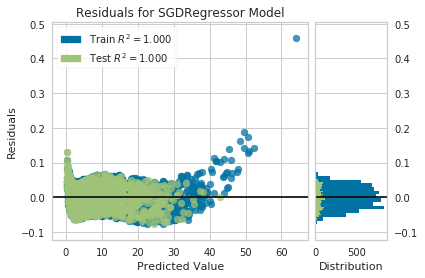

In [49]:
model = SGDRegressor(tol=0.0000000001, max_iter=250, penalty='elasticnet', alpha=0.0001, loss='epsilon_insensitive', epsilon=0.001, learning_rate='adaptive')
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)

visualizer.score(X_test, y_test)

visualizer.poof()

**LinearRegression**

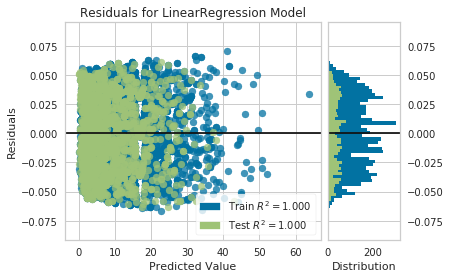

In [50]:
model = LinearRegression()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)

visualizer.score(X_test, y_test)

visualizer.poof()